# Classification Model

In [3]:
import cv2
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import *
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
import pandas as pd
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from collections import Counter
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [4]:
train_data_path="data/train"
test_data_path="data/val"

### Loading training data

In [5]:
# Finding final image size to be considered for model training.
img_sizes=[]
labels = [i for i in os.listdir(train_data_path) if i!=".ipynb_checkpoints"]
print("number of classes:",len(labels))
for i in labels:
    folderPath = os.path.join(f'{train_data_path}',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img_sizes.append(max(img.shape))
img_sizes=sorted(set(img_sizes))
if len(img_sizes)%2==0:
    final_size=(img_sizes[len(img_sizes)//2]+img_sizes[len(img_sizes)//2-1])//2
else:
    final_size=img_sizes[(len(img_sizes)-1)//2]

number of classes: 27


In [6]:
def resize_keep_aspect_ratio(img,desired_size):
    height, width = img.shape[:2]
    max_dim = max(height, width)
    ratio = desired_size / max_dim
    new_size = tuple([int(x * ratio) for x in (width, height)])
    resized_img = cv2.resize(img, (new_size[0], new_size[1]))
    
    # Adding pad to the image to get consistent shape
    pad_w = desired_size - new_size[0]
    pad_h = desired_size - new_size[1]
    top, bottom = pad_h // 2, pad_h - (pad_h // 2)
    left, right = pad_w // 2, pad_w - (pad_w // 2)
    img=cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return img

In [7]:
X_train = []
y_train = []
image_size = final_size
labels = [i for i in os.listdir(train_data_path) if i!=".ipynb_checkpoints"]
print("number of classes:",len(labels))
for i in labels: 
    folderPath = os.path.join(f'{train_data_path}',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=resize_keep_aspect_ratio(img,image_size)
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

number of classes: 27


In [8]:
print("training_data_length_without_smot",len(X_train))

training_data_length_without_smot 3359


In [9]:
class_details=Counter(y_train)
print(class_details)

Counter({'Hyundai.common': 195, 'Tata.common': 188, 'Kia.common': 172, 'Audi.common': 161, 'Mahindra.common': 161, 'Mercedes-Benz.common': 149, 'Ford.common': 148, 'Honda.common': 145, 'Fiat.common': 145, 'Datsun.common': 143, 'Jeep.common': 136, 'Mitsubishi.common': 135, 'MG-Motor.common': 135, 'Chevrolet.common': 135, 'Toyota.common': 133, 'BMW.common': 132, 'Volvo.frontal': 131, 'Maruti-Suzuki.common': 112, 'Renault.common': 111, 'Volkswagen.common': 108, 'Nissan.common': 103, 'ISUZU.common': 90, 'Skoda.common': 86, 'Jaguar.frontal': 81, 'Jaguar.rear': 62, 'Kia.new': 32, 'Tata.text': 30})


## Applying SMOT

In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
# Reshape the data back into image format
X_resampled = X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2], X_train.shape[3])
# resampled_path = 'data_oversampled/'
# for i, class_name in enumerate(labels):
#     class_path = os.path.join(resampled_path, class_name)
#     os.makedirs(class_path, exist_ok=True)
#     for j in range(len(X_resampled)):
#         if y_resampled[j] == class_name:
#             image_name = f"{class_name}_{j}.png"
#             image_path = os.path.join(class_path, image_name)
#             cv2.imwrite(image_path, X_resampled[j])

X_resampled,y_resampled=shuffle(X_resampled,y_resampled,random_state=101)
y_train_new = []
for i in y_resampled:
    y_train_new.append(labels.index(i))
y_train_new = tf.keras.utils.to_categorical(y_train_new)
print("training_data_length_after_smot",len(X_resampled))

training_data_length_after_smot 5265


In [11]:
class_details=Counter(y_resampled)
print(class_details)
y_resampled=y_train_new

Counter({'BMW.common': 195, 'Jeep.common': 195, 'Kia.common': 195, 'Nissan.common': 195, 'Toyota.common': 195, 'Datsun.common': 195, 'ISUZU.common': 195, 'Tata.text': 195, 'Jaguar.frontal': 195, 'Chevrolet.common': 195, 'Skoda.common': 195, 'Hyundai.common': 195, 'Maruti-Suzuki.common': 195, 'Honda.common': 195, 'Volvo.frontal': 195, 'Mahindra.common': 195, 'Tata.common': 195, 'MG-Motor.common': 195, 'Jaguar.rear': 195, 'Fiat.common': 195, 'Kia.new': 195, 'Ford.common': 195, 'Volkswagen.common': 195, 'Mitsubishi.common': 195, 'Audi.common': 195, 'Renault.common': 195, 'Mercedes-Benz.common': 195})


In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1/255.,
    validation_split=0.2
)

datagen.fit(X_train)
batch_size = 32
train_generator = datagen.flow(X_resampled, y_resampled, batch_size=batch_size,subset='training')
valid_generator=datagen.flow(X_resampled, y_resampled, batch_size=batch_size,subset='validation')

### Loading test data

In [14]:
X_test = []
y_test = []
image_size = final_size
for i in labels: 
    folderPath = os.path.join(f'{test_data_path}',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=resize_keep_aspect_ratio(img,image_size)
        X_test.append(img)
        y_test.append(i)
            
        
X_test = np.array(X_test)/255.0
y_test = np.array(y_test)
y_final_test = []
for i in y_test:
    y_final_test.append(labels.index(i))
y_final_test = tf.keras.utils.to_categorical(y_final_test)

### CNN Model

In [12]:
checkpoint_filepath = 'trinedmodel_with_smot/best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
Model_es = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 0)

Model = Sequential()
Model.add(Conv2D(32,(5,5),activation="relu", input_shape=(image_size,image_size,3)))
Model.add(MaxPooling2D((2,2)))
Model.add(Conv2D(128,(5,5),  activation="relu",padding="same"))
Model.add(MaxPooling2D((2,2)))
Model.add(Flatten())
Model.add(Dense(128,activation="softplus"))
Model.add(Dense(64,activation="sigmoid"))
Model.add(Dense(27,activation="softmax"))

Model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4) ,metrics=['accuracy'])
Model.summary()

history = Model.fit(train_generator, epochs=50,validation_data=valid_generator,callbacks=[Model_es,model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 128)       102528    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 128)               1

2023-11-29 23:37:20.441738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14932 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-11-29 23:37:20.442440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11215 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:18:00.0, compute capability: 7.5


Epoch 1/50


2023-11-29 23:37:21.816495: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2023-11-29 23:37:22.429887: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0fbcc0f140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 23:37:22.429938: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-29 23:37:22.429952: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-11-29 23:37:22.444155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701281242.554528  308157 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 [==============================] - ETA: 0s - loss: 2.7397 - accuracy: 0.2505
Epoch 1: val_accuracy improved from -inf to 0.48243, saving model to trinedmodel_with_smot/best_model_3.h5


/home/shahid/anaconda/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 18s 115ms/step - loss: 2.7397 - accuracy: 0.2505 - val_loss: 2.3388 - val_accuracy: 0.4824
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 1.9426 - accuracy: 0.6387
Epoch 2: val_accuracy improved from 0.48243 to 0.71510, saving model to trinedmodel_with_smot/best_model_3.h5
132/132 [==============================] - 15s 111ms/step - loss: 1.9426 - accuracy: 0.6387 - val_loss: 1.6562 - val_accuracy: 0.7151
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 1.3435 - accuracy: 0.8210
Epoch 3: val_accuracy improved from 0.71510 to 0.84520, saving model to trinedmodel_with_smot/best_model_3.h5
132/132 [==============================] - 15s 111ms/step - loss: 1.3435 - accuracy: 0.8210 - val_loss: 1.1845 - val_accuracy: 0.8452
Epoch 4/50
132/132 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.8946
Epoch 4: val_accuracy improved from 0.84520 to 0.88224, saving model to trinedmodel_with_s

In [13]:
score_cnn = Model.evaluate(X_test,y_final_test, verbose = 0)

print('final Test accuracy:', score_cnn[1])

final Test accuracy: 0.961002767086029


In [18]:
Model=tf.keras.models.load_model('trinedmodel_with_smot/best_model.h5')

print("Test accuracy is:",Model.evaluate(X_test,y_final_test)[1])

12/12 [==============================] - 0s 7ms/step - loss: 0.1531 - accuracy: 0.9666
Test accuracy is: 0.9665738344192505


In [19]:
ypred=Model.predict(X_test)

12/12 [==============================] - 0s 6ms/step


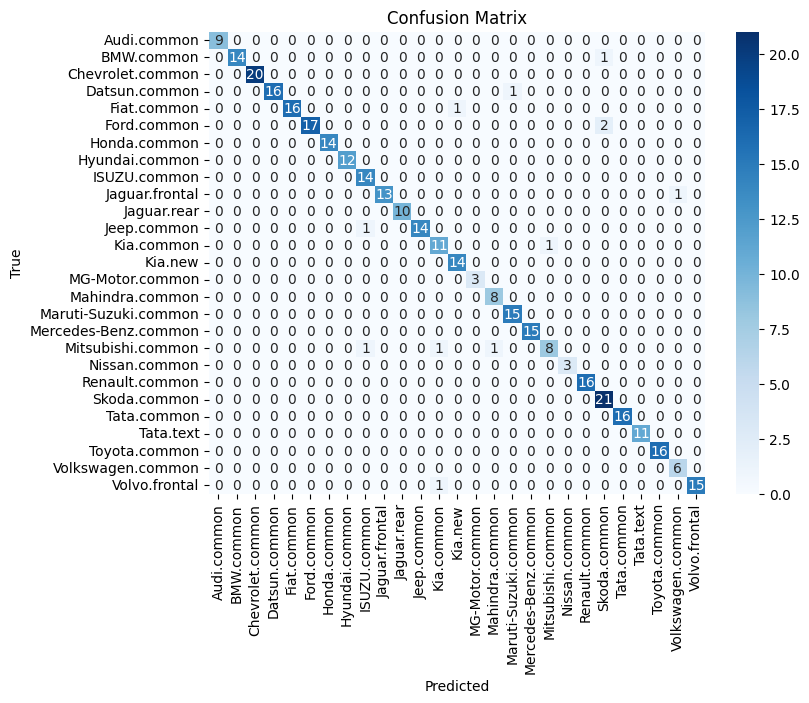


Classification Report:
                      precision    recall  f1-score   support

         Audi.common       1.00      0.94      0.97        17
          BMW.common       0.93      1.00      0.97        14
    Chevrolet.common       0.94      1.00      0.97        15
       Datsun.common       1.00      1.00      1.00        15
         Fiat.common       1.00      0.94      0.97        16
         Ford.common       1.00      1.00      1.00        16
        Honda.common       1.00      1.00      1.00        16
      Hyundai.common       0.88      1.00      0.93        21
        ISUZU.common       1.00      1.00      1.00        10
      Jaguar.frontal       0.89      1.00      0.94         8
         Jaguar.rear       0.86      1.00      0.92         6
         Jeep.common       1.00      0.93      0.97        15
          Kia.common       1.00      0.89      0.94        19
             Kia.new       1.00      1.00      1.00         3
     MG-Motor.common       1.00      0.93    

In [22]:
conf_matrix = confusion_matrix(y_final_test.argmax(axis=1), ypred.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique([labels[i] for i in y_final_test.argmax(axis=1)]), yticklabels=np.unique([labels[i] for i in y_final_test.argmax(axis=1)]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report([labels[i] for i in y_final_test.argmax(axis=1)], [labels[i] for i in ypred.argmax(axis=1)]))